# STM Transit Delay Data Modeling

## Overview

This notebook explores tree-based regression and classification models in order to find the one that predicts STM transit delays with the best accuracy.

## Data Description

`exp_trip_duration`: Expected duration of a trip, in seconds.<br>
`vehicle_bearing`: Direction that the vehicle is facing, from 0 to 360 degrees.<br>
`vehicle_speed`: Momentary speed measured by the vehicle, in meters per second.<br>
`vehicle_in_transit`: Indicates the vehicle stop status in relation with a stop that it's currently approaching or is at, 1 being "in transit" and 0 being "stopped".<br>
`occupancy_status`: Degree of passenger occupancy, from "Empty" to "Not accepting passengers".<br>
`route_type_Day`, `route_type_Night`, `route_type_Rush Hour High Frequency` : One-Hot features for types of bus lines<br>
`stop_group`: Stop cluster based on coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`stop_has_alert`: Indicates if current of previous stop has been moved or cancelled.<br>
`trip_phase_middle`, `trip_phase_end`: One-Hot features for trip progress.<br>
`exp_delay_prev_stop`: Expected duration between the previous and current stop, in seconds.<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair.<br>
`sch_rel_Scheduled`: One-Hot feature for schedule relationship.<br>
`day_of_week`: Day of week, from 0 (monday) to 6 (sunday).<br>
`time_of_day_midday`, `time_of_day_morning`, `time_of_day_night`: One-Hot features for time of day.<br>
`is_weekend`: Boolean value if the day of week in on the weekend.<br>
`is_peak_hour`: Boolean value indicating if the sheduled arrival time is at peak hour.<br>
`incident_count`: Number of incidents within 500 meters of the stop.<br>
`incident_nearby`: Indicates if an incident happened within 500 meters of the stop.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity`: Relative humidity at 2 meters above ground, in percentage.<br>
`dew_point`: Dew point temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction`: Wind direction at 10 meters above ground.<br>
`wind_gusts`: Gusts at 10 meters above ground as a maximum of the preceding hour.<br>
`delay`: Difference between real and scheduled arrival time, in seconds.<br>
`delay_class`: Delay category, from early to late.

## Imports

In [ ]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import cohen_kappa_score, confusion_matrix, f1_score, classification_report, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import sys
from xgboost import XGBClassifier, XGBRegressor

In [54]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import DELAY_CLASS

In [2]:
df = pd.read_parquet('../data/preprocessed.parquet')
print(f'Number of rows: {len(df)}')

Number of rows: 560386


## Split the data

In [3]:
# Separate features from target variables
X = df.drop(['delay', 'delay_class'], axis=1)
y = df[['delay', 'delay_class']]

In [ ]:
# Train-validation-test split (70-15-15)
# Stratify by delay class
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y['delay_class'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp['delay_class'], test_size=0.5, random_state=42)

del X_temp
del y_temp

In [5]:
# Separate delay and delay class
y_reg_train = y_train['delay']
y_reg_val = y_val['delay']
y_reg_test = y_test['delay']

y_class_train = y_train['delay_class']
y_class_val = y_val['delay_class']
y_class_test = y_test['delay_class']

Since only tree-based models are explored in this project, **scaling is not needed** because the models are not sensitive to the absolute scale or distribution of the features.

## Regression Model

### Random Forest Regressor

#### Fit Model

In [6]:
# Fit base model
rf_reg_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg_base.fit(X_train, y_reg_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

#### Evaluate Model

In [7]:
# Create dataframe to track metrics
reg_metrics_df = pd.DataFrame(columns=['model', 'params', 'MAE', 'RMSE', 'R²'])

In [ ]:
def add_reg_metrics(reg_metrics_df:pd.DataFrame, model, y_pred:pd.Series, y_val:pd.Series, model_name:str) -> pd.DataFrame:
	mae = mean_absolute_error(y_val, y_pred)
	rmse = root_mean_squared_error(y_val, y_pred)
	r2 = r2_score(y_val, y_pred)

	reg_metrics_df.loc[len(reg_metrics_df)] = [model_name, model.get_params(), mae, rmse, r2]
	return reg_metrics_df

In [ ]:
# Calculate metrics
y_pred = rf_reg_base.predict(X_val)
reg_metrics_df = add_reg_metrics(reg_metrics_df, rf_reg_base, y_pred, y_reg_val, 'rf_reg_base')
reg_metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_reg_base,74.168325,123.023754,-0.128347


**MAE**<br>
On average, the predictions are off by 74 seconds, which is not very good.

**RMSE**<br>
The higher RMSE compared to MAE suggests that there are some significant prediction errors that influence the overall error metric.

**R²**<br>
The negative R-squared score indicates the Random Forest Regressor is a very poor fit to the data.

### XGBoost Regressor

#### Fit Base Model

In [10]:
# Initialize the XGBoost model with default parameters
xg_reg_base = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

In [11]:
# Train a model
xg_reg_base.fit(X_train, y_reg_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

#### Evaluate Model

In [ ]:
y_pred = xg_reg_base.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, xg_reg_base, y_pred, y_reg_val, 'xg_reg_base')
reg_metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_reg_base,74.168325,123.023754,-0.128347
1,xg_reg_base,64.635206,109.522786,0.105720


**MAE:**

This is a slight improvement over the Random Forest model. The model is now, on average, 64.6 seconds off in its predictions, which is a 10 second reduction.

**RMSE:**

The RMSE has also decreased compared to the previous model indicating that the XGBoost model is performing better and has reduced the impact of large errors.

**R²:**

This is a substantial improvement from -12.83%. With an R-squared of 10.57%, the XGBoost model explains more variance in the data, which shows that it's capturing more of the underlying patterns than the previous model.

In [13]:
def plot_residuals(y_pred: pd.Series, y_true:pd.Series, model_name:str) -> None:
	fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

	# Predicted vs. actual values
	ax1.scatter(x=y_pred, y=y_true)
	ax1.set_title('Predicted vs. Actual values')
	ax1.set_xlabel('Predicted delay (seconds)')
	ax1.set_ylabel('Actual delay (seconds)')
	ax1.grid(True)

	# Residuals
	residuals = y_true - y_pred
	ax2.scatter(x=y_pred, y=residuals)
	ax2.set_title('Residual Plot')
	ax2.set_xlabel('Predicted Delay (seconds)')
	ax2.set_ylabel('Residuals (seconds)')
	ax2.axhline(0, linestyle='--', color='orange')
	ax2.grid(True)

	fig.suptitle('Residual Analysis', fontsize=18)
	fig.tight_layout()
	fig.savefig(f'../images/residual_analysis_{model_name}.png', bbox_inches='tight')
	plt.show()

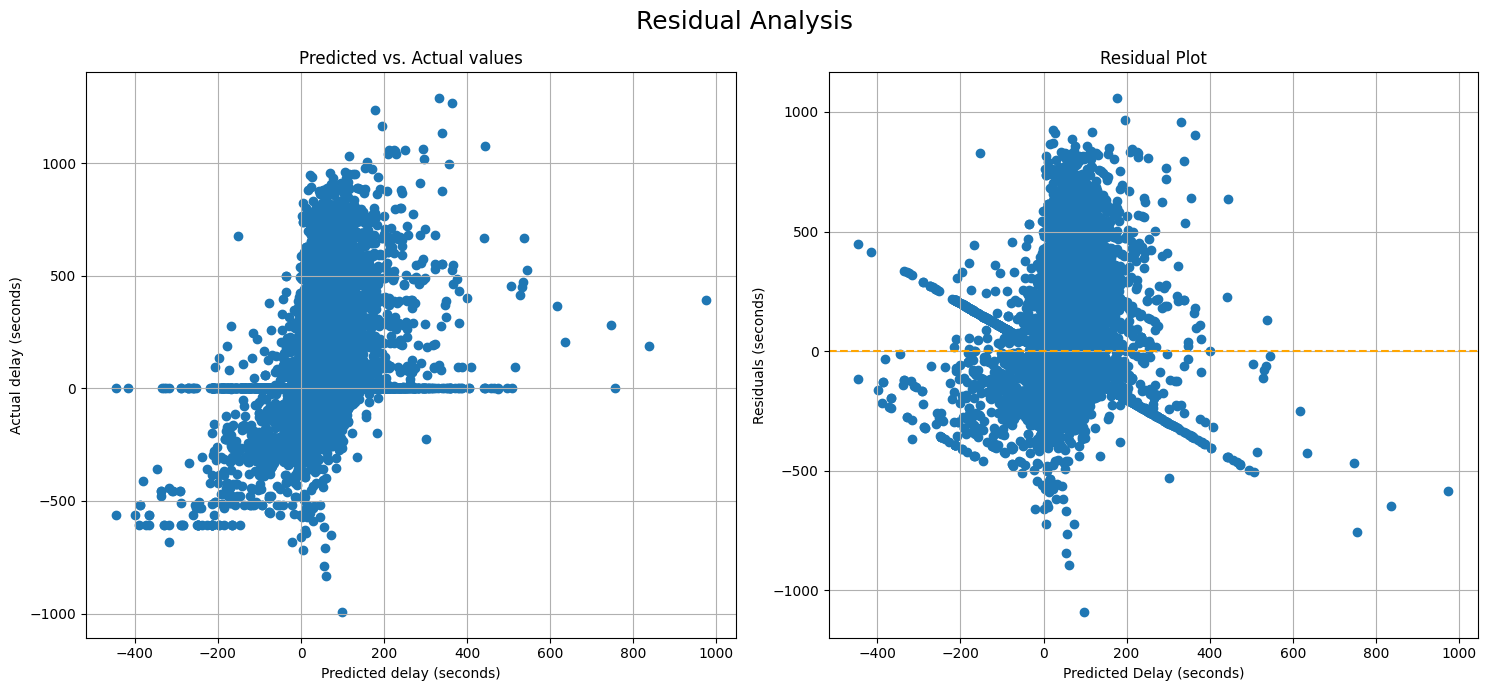

In [14]:
# Plot residual analysis
plot_residuals(y_pred, y_reg_val, 'xg_reg_base')

The predicted vs. actual plot shows a scatter of points, with some spread around the diagonal line, which indicates the model's predictions are not perfect but are reasonable. The spread of points suggests the model has a reasonable fit but doesn't handle extreme delays very well.

From the residual plot, it seems that the residuals are fairly spread out, with visible funnel shapes and most of the data clustered around 0, but also a significant spread both above and below the 0 line. This suggests there is no clear pattern in residuals (not biased in one direction). Also, it suggests the residuals appear to increase as the predicted delay increases, meaning the model prediction errors are larger for higher predicted delays (heteroscedasticity). This means the model is better at predicting small delays than large delays.

#### Hyperparameter tuning

In [16]:
# Create a GridSearchCV object
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
				estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
				param_grid=param_grid,
				cv=3,
				verbose=1,
				n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_reg_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             verbose=1)

In [17]:
# Use the best model
xg_reg_tuned = grid_search.best_estimator_
best_params = grid_search.best_params_

In [ ]:
# Evaluate the best model
y_pred = xg_reg_tuned.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, xg_reg_tuned, y_pred, y_reg_val, 'xg_reg_tuned')
reg_metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_reg_base,74.168325,123.023754,-0.128347
1,xg_reg_base,64.635206,109.522786,0.105720
2,xg_reg_tuned,64.420699,109.068104,0.113130


**MAE:**

This is a small improvement over the previous MAE of 64.63 seconds. The model is now, on average, 64.42 seconds off in its predictions, which is a good step forward.

**RMSE:**

The RMSE has decreased slighly again, from 109.52 to 109.07 seconds, indicating that the model has become slightly more accurate, especially in handling larger errors.

**R²:**

The R-squared value has increased from 10.57% to 11.31%, suggesting that the model is now explaining a bit more of the variance in the data, which is an improvement.

#### Feature Importances

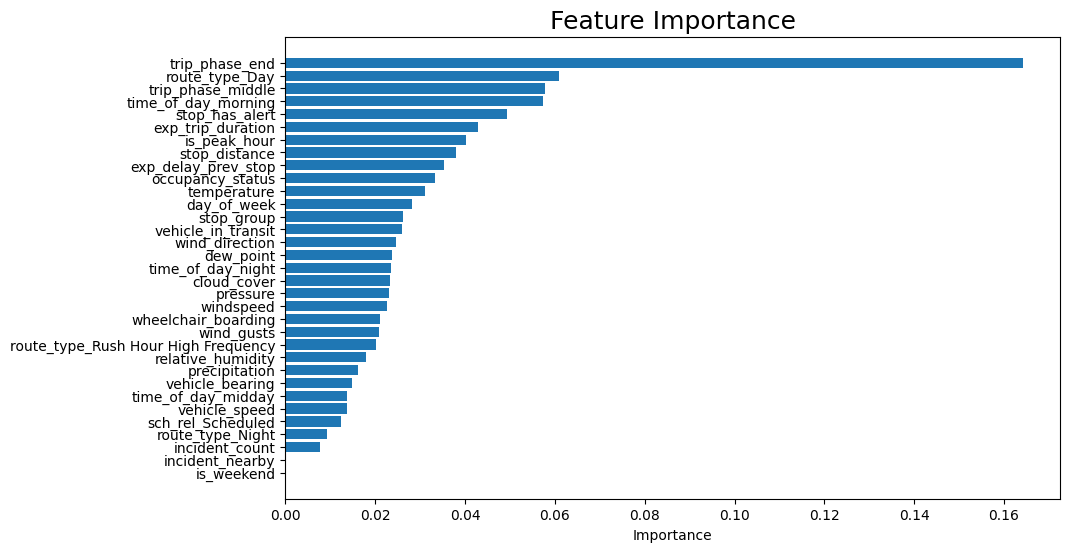

In [ ]:
# Extract feature importances
importance = xg_reg_base.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importance', fontsize=18)
plt.savefig('../images/feat_importance_xg_reg_tuned.png', bbox_inches='tight')
plt.show()

Interpret model

#### SHAP Plots

In [ ]:
# Create explainer with smaller validation set
X_val_sample = X_val[:1000]
explainer = shap.Explainer(xg_reg_tuned, X_val_sample)
shap_values = explainer(X_val_sample)

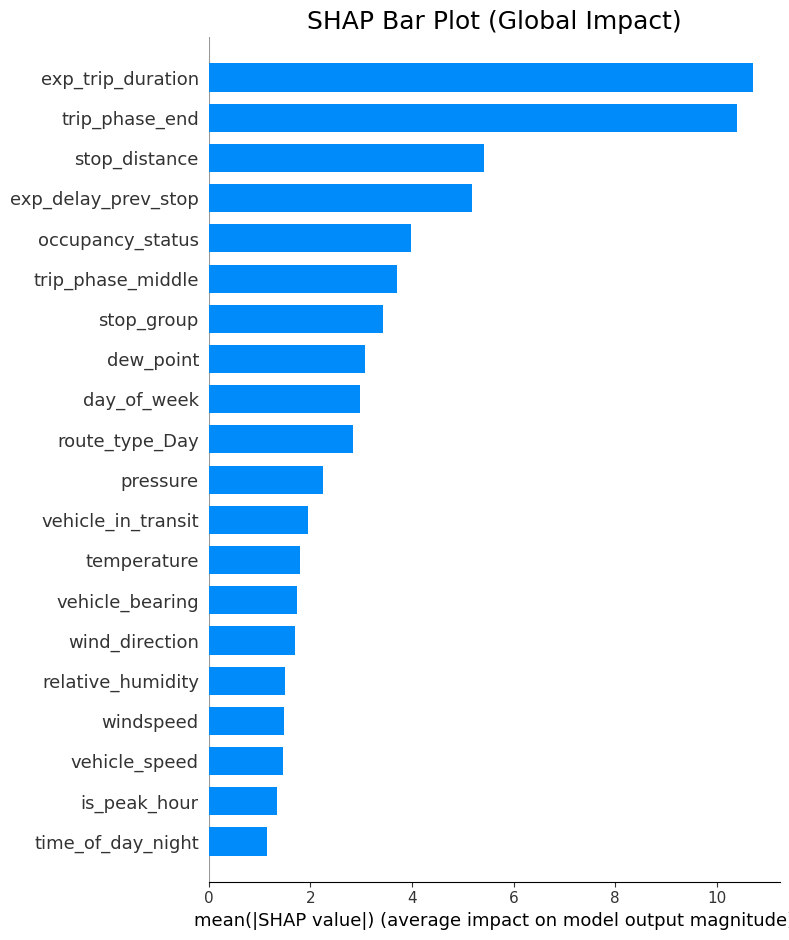

In [21]:
# Summary plot (bar chart)
shap.summary_plot(shap_values, X_val_sample, plot_type='bar', show=False)

plt.title('SHAP Bar Plot (Global Impact)', fontsize=18)
plt.tight_layout()
plt.savefig('../images/shap_barplot_xg_reg_tuned.png', bbox_inches='tight')
plt.show()

Interpret plot

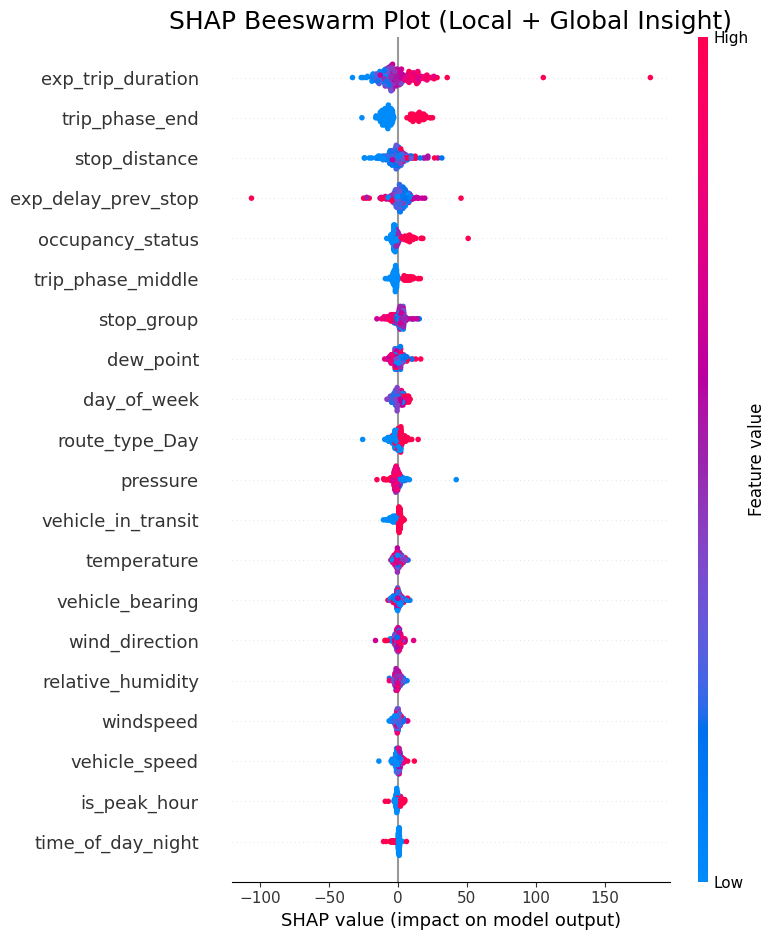

In [22]:
# Summary plot (beeswarm: shows direction and spread)
shap.summary_plot(shap_values, X_val_sample, show=False)

plt.title('SHAP Beeswarm Plot (Local + Global Insight)', fontsize=18)
plt.tight_layout()
plt.savefig('../images/shap_beeswarm_plot_xg_reg_tuned.png', bbox_inches='tight')
plt.show()

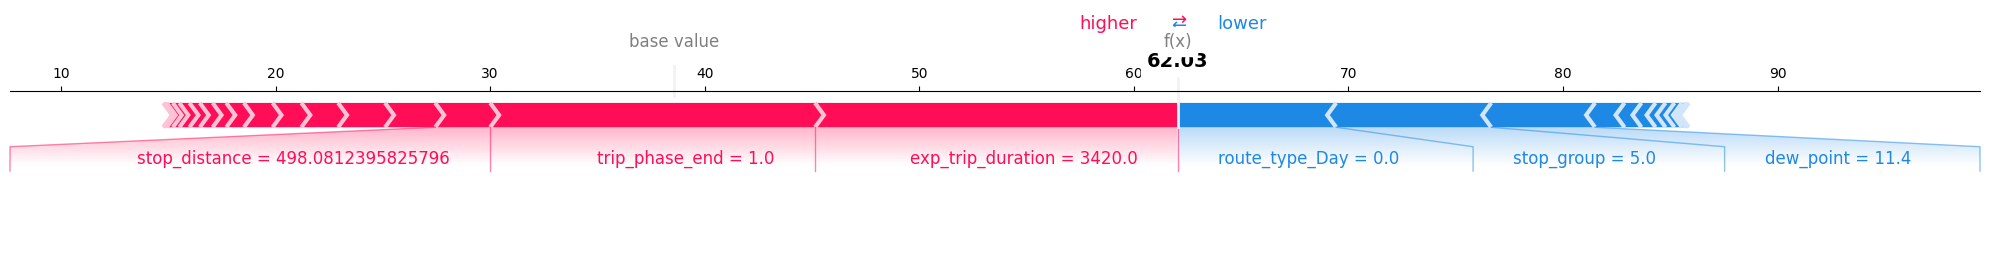

In [25]:
# Force Plot (local explanation for one prediction)
instance = X_val_sample.iloc[0:1]
shap_values = explainer(instance)

shap.initjs()
shap.force_plot(shap_values.base_values, shap_values.values, instance, matplotlib=True, show=False)

plt.tight_layout()
plt.savefig('../images/shap_force_plot_xg_reg_tuned.png', bbox_inches='tight')
plt.show()

Interpret plot

#### SHAP-Based Feature Pruning

In [27]:
# Calculate mean SHAP per feature
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': X_val.columns,
    'mean_abs_shap': shap_abs_mean
}).sort_values('mean_abs_shap', ascending=False)
shap_df

,feature,mean_abs_shap
0,exp_trip_duration,16.893887
12,trip_phase_end,15.137814
5,route_type_Day,7.393263
8,stop_group,7.226290
25,dew_point,4.838663
9,stop_distance,2.560932
28,pressure,2.338160
16,day_of_week,2.187882
31,wind_direction,1.712414
11,trip_phase_middle,1.373505


In [29]:
# Identify low impact features
threshold = 0.05
low_shap_features = shap_df[shap_df['mean_abs_shap'] < threshold]
print('Features with low SHAP impact to remove:\n')
print(low_shap_features)

Features with low SHAP impact to remove:

                feature  mean_abs_shap
14  wheelchair_boarding       0.035606
27        precipitation       0.029786
15    sch_rel_Scheduled       0.000000
6      route_type_Night       0.000000
23      incident_nearby       0.000000
22       incident_count       0.000000


In [ ]:
# Keep best features
full_features = X.columns.to_list()
features_to_drop = low_shap_features['feature'].tolist()
best_features = list(set(full_features) - set(features_to_drop))

In [39]:
# Drop columns from dataset
X_train_best = X_train[best_features]
X_val_best = X_val[best_features]
X_test_best = X_test[best_features]

#### Retrain Model With Pruned Features

In [40]:
xg_reg_retrained = XGBRegressor(
  	objective='reg:squarederror',
  	n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
  	random_state=42)

xg_reg_retrained.fit(X_train_best, y_reg_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = xg_reg_retrained.predict(X_val_best)

reg_metrics_df = add_reg_metrics(reg_metrics_df, xg_reg_retrained, y_pred, y_reg_val, 'xg_reg_retrained')
reg_metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_reg_base,74.168325,123.023754,-0.128347
1,xg_reg_base,64.635206,109.522786,0.105720
2,xg_reg_tuned,64.420699,109.068104,0.113130
3,xg_reg_retrained,64.476852,109.194228,0.111077


The performance got slightly worse.

#### Retune Hyperparameters

In [42]:
grid_search = GridSearchCV(
				estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
				param_grid=param_grid,
				cv=3,
				verbose=1,
				n_jobs=-1)

grid_search.fit(X_train_best, y_reg_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             verbose=1)

In [45]:
# Use the best model
xg_reg_final = grid_search.best_estimator_
best_params = grid_search.best_params_

In [ ]:
# Evaluate the best model
y_pred = xg_reg_final.predict(X_val_best)

reg_metrics_df = add_reg_metrics(reg_metrics_df, xg_reg_final, y_pred, y_reg_val, 'xg_reg_final')
reg_metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_reg_base,74.168325,123.023754,-0.128347
1,xg_reg_base,64.635206,109.522786,0.105720
2,xg_reg_tuned,64.420699,109.068104,0.113130
3,xg_reg_retrained,64.476852,109.194228,0.111077
4,xg_reg_final,64.476852,109.194228,0.111077
5,xg_reg_final,64.476852,109.194228,0.111077


In [49]:
# Get best model
reg_metrics_df.drop('params', axis=1).nsmallest(n=1, columns='RMSE').iloc[0]

model    xg_reg_tuned
MAE         64.420699
RMSE       109.068104
R²            0.11313
Name: 2, dtype: object

The metrics havent changed at all, meaning the best regression model is the tuned XGBoost Regressor will all features.

## Classification Model

### Random Forest Classifier

#### Fit Base Model

In [ ]:
# class_weight helps for rare classes
rf_class_base = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1) 
rf_class_base.fit(X_train, y_class_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

#### Evaluate Model

In [64]:
class_metrics_df = pd.DataFrame(columns=['model', 'params', 'f1_macro', 'kappa'])

In [68]:
def add_class_metrics(class_metrics_df:pd.DataFrame, model, y_pred:pd.Series, y_val:pd.Series, model_name:str) -> pd.DataFrame:
	f1_macro = f1_score(y_val, y_pred, average='macro')
	kappa = cohen_kappa_score(y_val, y_pred)

	class_metrics_df.loc[len(class_metrics_df)] = [model_name, model.get_params(), f1_macro, kappa]
	return class_metrics_df

In [70]:
y_pred = rf_class_base.predict(X_val)

class_metrics_df = add_class_metrics(class_metrics_df, rf_class_base, y_pred, y_class_val, 'rf_class_base')
class_metrics_df[['model', 'f1_macro', 'kappa']]

,model,f1_macro,kappa
0,rf_class_base,0.44871,0.121934
1,rf_class_base,0.44871,0.121934


Interpret results

In [73]:
# Classification report
labels = DELAY_CLASS.values()
print(classification_report(y_class_val, y_pred, target_names=labels))

              precision    recall  f1-score   support

       Early       0.30      0.24      0.27      2131
     On Time       0.89      0.92      0.91     73863
        Late       0.21      0.15      0.17      8064

    accuracy                           0.83     84058
   macro avg       0.47      0.44      0.45     84058
weighted avg       0.81      0.83      0.82     84058



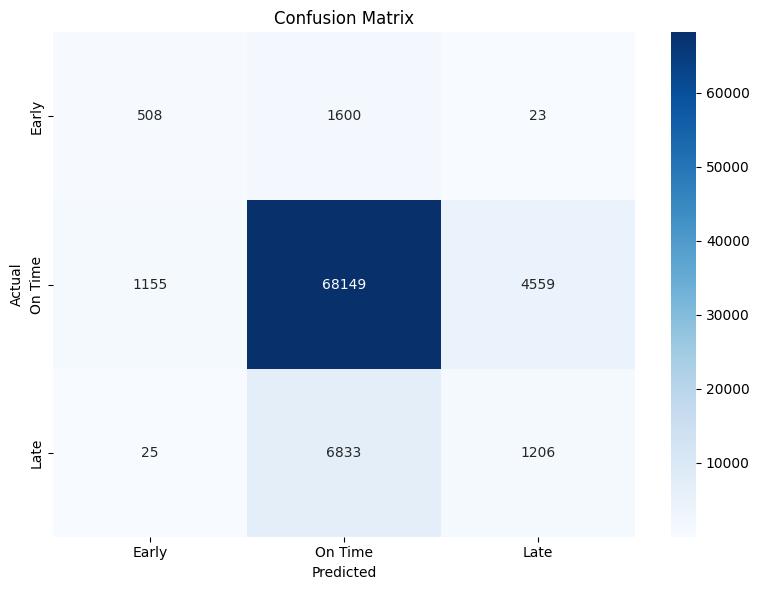

In [ ]:
# Confusion matrix heatmap
cm = confusion_matrix(y_class_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('../images/cm_rf_class_base.png', bbox_inches='tight')
plt.show()

Interpret results

#### Hyperparameter tuning

In [ ]:
# Run RandomizedSearch to save computation time

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 400, 600],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20, # 20 combinations
    cv=3,
    verbose=1,
    scoring='f1_macro', # optimize for macro F1
    n_jobs=-1,
    random_state=42
)

# Fit search
random_search.fit(X_train, y_class_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 4.4min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 4.4min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 4.4min
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 6.0min
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 6.0min
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples

In [ ]:
# Best model
rf_class_tuned = random_search.best_estimator_
best_params = random_search.best_params_

In [ ]:
y_pred = rf_class_tuned.predict(X_val)

class_metrics_df = add_class_metrics(class_metrics_df, rf_class_tuned, y_pred, y_class_val, 'rf_class_tuned')
class_metrics_df[['model', 'f1_macro', 'kappa']]

## Final Model

### Fit Model

### Evaluate on Test Set

### Plot residuals

### Make Prediction

### Export Data

## End